<a href="https://colab.research.google.com/github/michaelsong4399/asteroseismology/blob/yihong/NNFourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve
!pip install astroquery
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install pandas
!pip install tensorflow
!pip install astropy

     |████████████████████████████████| 235kB 8.8MB/s 
     |████████████████████████████████| 788kB 26.5MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 256kB 17.8MB/s 
     |████████████████████████████████| 22.2MB 1.5MB/s 
     |████████████████████████████████| 6.5MB 26.5MB/s 
     |████████████████████████████████| 368kB 55.3MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 3.2MB 41.7MB/s 
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12779 sha256=9b741cbd600bc3f56f52916c52a33a24ee574fe804ba12d73031592927b64b6b
  Stored in directory: /root/.cache/pip/wheels/9b/90/81/098fc66ee56166d63c9a8fc0a9672ae7b3423396a588ec952a
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11377 sha256=a92f11c756bdf2c1eb85b625d8d3be6850446cba01a44f0a21f9438ee4544222
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e

In [2]:
import lightkurve as lk
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
import scipy
import pandas as pd 
from scipy import interpolate
#tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Cycles
    #21
        #cycle_21 = []
        
        #Start 1 March 1976
        #End 1 September 1986
        
    #22
        #cycle_22 = [2446674.5,2450296.5]
        
        #Start: 1 September 1986 2446674.5
        #End: 1 August 1996 2450296.5
        
    #23
cycle_23 = [2450296.5,2454801.5]
        
        #Start: 1 August 1996 2450296.5
        #End: 1 December 2008 2454801.5
        
    #24
cycle_24 = [2454801.5,2458940.5]
        
        #Start: 1 December 2008 2454801.5
        #End: 1 May 2020 2458970.5
        #NOTE: Due to dataset limitation, only analyzed up to 2458940.5
        

# Surface Velocity

In [5]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/allsites-alldata-waverage-fill.fits')

hdul.info()

tsdata = hdul[0].data
#         SIMPLE  =                    T / Written by IDL:  Tue Jan 19 11:22:20 2016      
#         BITPIX  =                  -64 /Real*8 (double precision)                       
#         NAXIS   =                    2 /                                                
#         NAXIS1  =                    2 /                                                
#         NAXIS2  =             24455519 /                                                
DSTART =        2442778.50000 #Data start (Julian)      1/1/1976 0:00:00                        
DEND   =        2458940.50000 #Data end (Julian)        4/1/2020 0:00:00                       
#         STATIONS= 'na ca cb su iz la lb mo' /Stations Used                              
#         METHOD  = 'waverage'           /Overlap Method                                  
#         CADENCE = '40      '           /Timeseries Cadence                              
#         N-THRES =                   80 /Noise Rejection Threshold                       
#         GAPFILL =                    1 /GapFill                                         
#         FILL    =             0.638866 /Duty Cycle   
#
#         ~2160 datapoints per day

Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   


In [6]:
def getSV(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[1]

In [7]:
def getSV_index(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[0]

In [8]:
print(getSV(cycle_23))
print(getSV_index(cycle_23))

[ 0.52007627  0.87248993  0.11934945 ...  0.25079036 -1.0275805
 -0.95429337]
[2450296.50033958 2450296.50080254 2450296.50126551 ... 2454801.49915418
 2454801.49961714 2454801.50008011]


# Sunspot Number

In [9]:
#sunspot_Day = np.genfromtxt('data/SN_d_tot_V2.0.csv',delimiter=';')
sunspot_Day = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/SN_d_tot_V2.0.csv',delimiter=';')
SNSTART_Day = 2385070.5
SNEND_day = 2459000.5

#sunspot_Month = np.genfromtxt('data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = sunspot_Month[828:]

In [10]:
def getSN_Day(cycle):
    if cycle[1] >= SNEND_day:
        cycle[1] = SNEND_day
    cycle = np.subtract(cycle, SNSTART_Day)
    sn = sunspot_Day.T[4][int(cycle[0]):int(cycle[1])]
    
    npout = [[0,0]]
    for i in range(len(sn)):
        npout = np.append(npout,[[i+SNSTART_Day+cycle[0],sn[i]]],0)
    npout = npout[1:]
    return npout

In [11]:
def getSNAverage(cycle,length):
    
    npout = [[0,0]]
    total = 0
    valid_count = 0
    start = cycle[0][0]
    for i in range(len(cycle)):
        if cycle[i][1] >= 0:
            total += cycle[i][1]
            valid_count += 1
        if (i+1) % length < 1 or i == len(cycle)-1:
            npout = np.append(npout,[[start,total/valid_count]],0)
            total = 0
            valid_count = 0
            if i == len(cycle)-1:
                break
            start = cycle[i+1][0]
    npout = npout[1:]
    return npout

In [12]:
getSN_Day(cycle_23)

array([[2.4502965e+06, 2.6000000e+01],
       [2.4502975e+06, 3.1000000e+01],
       [2.4502985e+06, 3.1000000e+01],
       ...,
       [2.4547985e+06, 0.0000000e+00],
       [2.4547995e+06, 0.0000000e+00],
       [2.4548005e+06, 0.0000000e+00]])

In [13]:
getSNAverage(getSN_Day(cycle_23),365)

array([[2.45029650e+06, 1.45643836e+01],
       [2.45066150e+06, 6.19232877e+01],
       [2.45102650e+06, 1.21704110e+02],
       [2.45139150e+06, 1.69175342e+02],
       [2.45175650e+06, 1.53487671e+02],
       [2.45212150e+06, 1.78747945e+02],
       [2.45248650e+06, 1.29030137e+02],
       [2.45285150e+06, 7.85397260e+01],
       [2.45321650e+06, 5.33808219e+01],
       [2.45358150e+06, 3.17945205e+01],
       [2.45394650e+06, 1.95780822e+01],
       [2.45431150e+06, 6.09041096e+00],
       [2.45467650e+06, 2.98400000e+00]])

# Preprocessing


In [29]:
def getPeriodogram(time,freq):
    lc = lk.LightCurve(time=time.tolist(),flux=freq.tolist())
    lc = lc.remove_nans()
    pg = lc.to_periodogram(method='lombscargle', normalization='psd',minimum_frequency=1000, maximum_frequency=5000)
    #ax = pg.plot()
    pg_data = pg.to_table()
    data = np.array(pg_data['power']).T#.tolist()


    # pg.smooth(method='boxkernel', filter_width=1.)#.plot(ax=ax, label='Smoothed', c='red', lw=2)
    # #ax.axvline(pg.frequency_at_max_power.value, lw=2, ls='dashed')
    # snr = pg.flatten()
    # seis = snr.to_seismology()
    # numax = seis.estimate_numax()
    # numax = float(str(numax)[0:7])
    return data

In [30]:
pg = getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000])

In [31]:
print(pg[0:5])

[9.43163103e-06 9.01683009e-06 9.53623339e-05 4.53297555e-05
 6.06767015e-05]


In [80]:
#Debug
# time,freq,length,interval = getSV_index(cycle_23),getSV(cycle_23),182.5,91.25

# length = int(length * 2160)
# interval = int(interval * 2160)
# #npout = [[0,0]]
# check = True
# for start in range(0,len(time),interval):
#     if start + length >= len(time):
#         length = len(time) - start
#     if check:
#       check = False
#       npout1d = np.array([getPeriodogram(time[start:start+length],freq[start:start+length])])
#     else:
#       temp = np.array([getPeriodogram(time[start:start+length],freq[start:start+length])])
#       if temp.size == npout1d[-1].size:
#         npout1d = np.append(npout1d,temp,0)
#       else:
#         print(temp.shape,npout1d.shape)
#     print(npout1d.shape)

In [81]:
def tsNumax(time,freq,length,interval):
  length = int(length * 2160)
  interval = int(interval * 2160)
  #npout = [[0,0]]
  check = True
  for start in range(0,len(time),interval):
      if start + length >= len(time):
          length = len(time) - start
      if check:
        check = False
        npout1d = np.array([getPeriodogram(time[start:start+length],freq[start:start+length])])
      else:
        temp = np.array([getPeriodogram(time[start:start+length],freq[start:start+length])])
        if temp.size == npout1d[-1].size:
          npout1d = np.append(npout1d,temp,0)
  return npout1d

In [82]:
numax_cycle_23_182 = tsNumax(getSV_index(cycle_23),getSV(cycle_23),182.5,91.25)
#print(numax_cycle_23)

In [ ]:
numax_cycle_24_182 = tsNumax(getSV_index(cycle_24),getSV(cycle_24),182.5,91.25)

In [84]:
print(numax_cycle_23_182)

[[2.97696466e-05 8.19987704e-06 1.05384707e-04 ... 3.20928767e-05
  3.64857617e-05 7.95015702e-06]
 [1.89955818e-05 4.13591288e-07 8.07475522e-05 ... 1.53489174e-05
  3.13521866e-05 8.11285198e-06]
 [2.30028433e-05 9.34467566e-05 1.23647725e-04 ... 3.59797493e-06
  1.25009879e-05 2.82519005e-05]
 ...
 [1.96578274e-05 4.02596243e-06 9.75902648e-05 ... 2.66164597e-06
  4.55807005e-05 4.70582693e-05]
 [5.72381487e-06 7.66772419e-05 3.20141675e-06 ... 6.67835719e-06
  3.86473800e-07 1.02447020e-04]
 [5.38898835e-05 1.23581167e-05 6.63245233e-05 ... 6.38514917e-06
  7.26191132e-05 6.05639946e-05]]


# SN

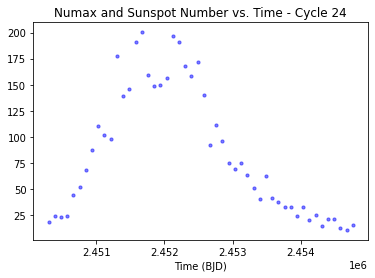

100


In [222]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),91.25)
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]

plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 24')

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(datax_SN,datay_SN, s = 10, c='blue', alpha=0.5)
plt.show()
print(data_SN.size)


In [223]:
train_x = numax_cycle_23_182
train_y_pre = datay_SN[:-2]
print(train_y_pre)
print(train_x.shape, train_y_pre.shape)
#train_x = np.reshape(train_x, (-1, 2160))
print(train_x.shape)
print(train_x)

# normalize
max = float(np.max(train_y_pre))
train_y = np.divide(train_y_pre,max)
print(np.max(train_y),train_y.shape)

#Train-test set
train_test_x = numax_cycle_24_182
train_test_y = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_24),0),91.25)[:-2].T[1]

[ 18.51282051  24.54385965  22.72131148  23.80263158  44.
  52.14772727  67.74725275  87.16483516 110.29347826 101.52747253
  97.91208791 177.20879121 139.47826087 146.24175824 191.04395604
 200.26373626 159.13043478 148.7032967  149.71428571 156.34065934
 196.76086957 191.28571429 168.20879121 158.53846154 172.11956522
 140.05494505  91.75824176 111.71428571  95.54347826  74.86666667
  69.38461538  75.          63.46666667  51.38461538  40.65555556
  62.49425287  41.1744186   37.86363636  33.10769231  32.25
  24.05263158  32.6875      20.1875      25.5         14.26470588
  21.44117647  21.          12.15384615]
(48, 63072) (48,)
(48, 63072)
[[2.97696466e-05 8.19987704e-06 1.05384707e-04 ... 3.20928767e-05
  3.64857617e-05 7.95015702e-06]
 [1.89955818e-05 4.13591288e-07 8.07475522e-05 ... 1.53489174e-05
  3.13521866e-05 8.11285198e-06]
 [2.30028433e-05 9.34467566e-05 1.23647725e-04 ... 3.59797493e-06
  1.25009879e-05 2.82519005e-05]
 ...
 [1.96578274e-05 4.02596243e-06 9.75902648e-05 

In [313]:
tf.test.gpu_device_name()
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()

model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))
model.add(layers.Dense(1024, activation='relu', input_shape=(train_x.shape)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48, 1024)          64586752  
_________________________________________________________________
dense_1 (Dense)              (None, 48, 512)           524800    
_________________________________________________________________
dense_2 (Dense)              (None, 48, 512)           262656    
_________________________________________________________________
dense_3 (Dense)              (None, 48, 512)           262656    
_________________________________________________________________
dense_4 (Dense)              (None, 48, 128)           65664     
_________________________________________________________________
dense_5 (Dense)              (None, 48, 128)           16512     
_________________________________________________________________
dense_6 (Dense)              (None, 48, 128)           1

In [314]:
# model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [315]:
history = model.fit(train_x, train_y, epochs=50,
                   validation_data=(train_test_x, train_test_y))

Epoch 1/50
2/2 [==============================] - 2s 771ms/step - loss: 0.2874 - accuracy: 0.0000e+00 - val_loss: 4168.2236 - val_accuracy: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 1s 453ms/step - loss: 0.2667 - accuracy: 0.0000e+00 - val_loss: 4165.3198 - val_accuracy: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 1s 428ms/step - loss: 0.2530 - accuracy: 0.0000e+00 - val_loss: 4155.9556 - val_accuracy: 0.0000e+00
Epoch 4/50
2/2 [==============================] - 1s 445ms/step - loss: 0.1896 - accuracy: 0.0000e+00 - val_loss: 4126.5894 - val_accuracy: 0.0000e+00
Epoch 5/50
2/2 [==============================] - 1s 446ms/step - loss: 0.0962 - accuracy: 0.0139 - val_loss: 4110.3965 - val_accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 1s 442ms/step - loss: 0.1310 - accuracy: 0.0000e+00 - val_loss: 4129.3799 - val_accuracy: 0.0000e+00
Epoch 7/50
2/2 [==============================] - 1s 441ms/step - loss: 0.0916 - accuracy: 0.0000e

In [316]:
pred_y = model.predict(train_x)

In [317]:
pred_y = pred_y.reshape(-1)
#pred_y = np.multiply(pred_y,353.0)
print(pred_y)

[0.09640088 0.12332181 0.11601796 0.12113749 0.22025107 0.26190126
 0.33932492 0.43917996 0.55221045 0.5071809  0.49250576 0.88344646
 0.69975233 0.7372091  0.96186084 1.0066053  0.79912674 0.7415407
 0.7493547  0.7809258  0.986382   0.9515314  0.84468925 0.7952111
 0.8603548  0.6983777  0.46258208 0.5598347  0.48045635 0.3759781
 0.3488109  0.37503508 0.32062653 0.2576335  0.2021693  0.31518364
 0.20531993 0.18562597 0.16794044 0.16246924 0.12290636 0.16812164
 0.10790277 0.12773502 0.08571596 0.099338   0.09728454 0.08223653]


(48,) (48,) (48,)


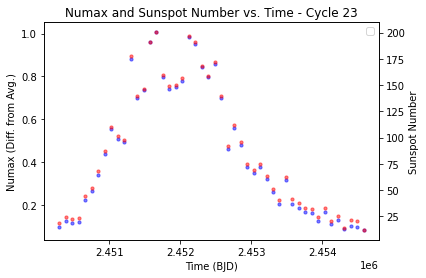

In [318]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),91.25)[:-2]
#data_SN = np.ma.masked_equal(getSN_Day(cycle_23),0)
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]
print(datax_SN.shape, datay_SN.shape, pred_y.shape)

figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 23')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('Numax (Diff. from Avg.)')
axis_1.scatter(datax_SN,pred_y, s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.scatter(datax_SN,datay_SN, s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()

In [319]:
print(numax_cycle_24_182)

[[5.12939512e-06 2.74658667e-05 1.30162586e-04 ... 1.87572875e-05
  1.07630421e-04 1.14339673e-05]
 [8.86564049e-06 1.51447890e-05 1.33395100e-04 ... 9.20475404e-05
  6.35275028e-06 3.08707556e-05]
 [7.59165790e-06 4.96486497e-05 1.19273949e-05 ... 1.41437212e-04
  2.59161848e-05 1.19579854e-05]
 ...
 [5.68322111e-06 6.56638822e-05 2.34159817e-05 ... 2.65698299e-05
  9.17601694e-05 1.25909167e-05]
 [3.51589832e-05 2.43807003e-05 2.50134107e-05 ... 9.85385126e-06
  7.86522784e-05 1.88420818e-05]
 [7.53107874e-07 7.63718514e-06 1.56116418e-05 ... 5.53692171e-05
  2.80536905e-05 2.98976611e-05]]


In [320]:

test_x = numax_cycle_24_182
print(test_x.shape)
test_y = model.predict(test_x)
test_y = test_y.reshape(-1)
print(test_y)

(44, 63072)
[0.27947515 0.28479683 0.2789734  0.27634087 0.2941251  0.29968742
 0.2712114  0.27705738 0.298961   0.3356722  0.3634212  0.3978752
 0.3331944  0.32700595 0.3403941  0.32372558 0.3215942  0.32891697
 0.3324651  0.40294334 0.4785139  0.42630017 0.3867059  0.41509834
 0.38422903 0.3866037  0.3466109  0.368846   0.39191863 0.3197612
 0.33188182 0.29607773 0.2849308  0.3063212  0.3040893  0.27310538
 0.25589377 0.25831527 0.28732815 0.28734916 0.304044   0.26856607
 0.24458233 0.26662335]


(44,) (44,) (44,)


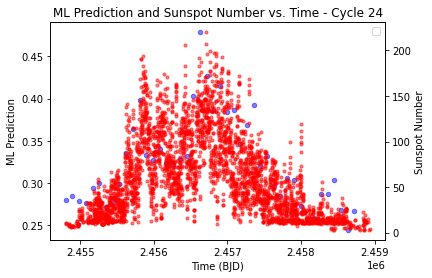

In [323]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_24),0),91.25)[:-2]
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]
data2_SN = np.ma.masked_equal(getSN_Day(cycle_24),0)[:-1]
data2x_SN = data2_SN.T[0]
data2y_SN = data2_SN.T[1]
print(datax_SN.shape, datay_SN.shape, test_y.shape)

figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 24')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('ML Prediction')
axis_1.scatter(datax_SN,test_y, s = 20, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.scatter(data2x_SN,data2y_SN, s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()